# Fraction of FE domains vs Voltage

* [Load data](#Load-data)
* [Correct shift](#Shift-correction)
* [Correlate](#Correlations) - test
* [Segment domains](#Segmentation)
* [Save](#Save-data)
* [Threshold experiment](#Single-thresholding)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import lib.calc as c
import lib.calc as c
import scipy.ndimage as nd
from skimage import filters, exposure, restoration, morphology, feature, measure
from ipywidgets import interact
from silx.io import specfile as spec
from matplotlib import patches

%matplotlib inline

In [2]:
def plotall(ls):
    fig, ax = plt.subplots(3,6,figsize=(15,12))
    axes = ax.ravel()

    for index, ax in enumerate(axes):
        try:
            im = ax.imshow(ls[index])
            ax.set_title('{0} V'.format(voltages[index]))
            plt.colorbar(im,ax=ax)
        except IndexError:
            pass
    plt.show()

In [3]:
voltages = [5,10,20,30,40,50,60,70,-10,-20,-30,-40,-50,-60,-70,100,150]

In [35]:
sf = '/mntdirect/_data_id01_inhouse/IHR/HC3313/spec/e17089_fast_00022.spec'
rois_103 = ['roi1', 'roi3', 'roi2', 'roi4', 'roi5']
scan_list = [10,15,21,27,33,39,45,51,57,63,69,75,80,85,90]

# for i,scan in enumerate(scan_list):
#     scan_list[i] = scan - 1
# print(scan_list)    

# scan_list.append(94)
# scan_list.append(96)
print(scan_list)    


small_1 = dict()
for scan in scan_list:
    small_1[scan] = c.read_kmap(sf, scan, rois_103) # out is piy, pix, int per each roi

[10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 85, 90]


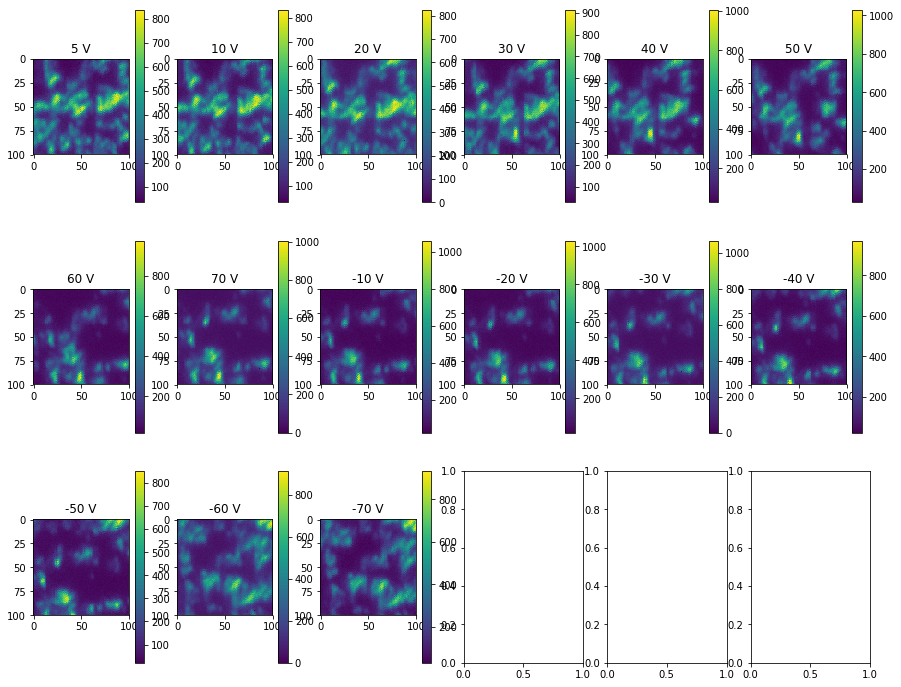

In [43]:
roi = 'roi1'
small_roi = []
for scan in scan_list:
    small_roi.append(small_1[scan][roi][2].T[::-1]) # list of roi2 intensity ndarrays
    
roi = 'roi5'
roi5 = []
for scan in scan_list:
    roi5.append(small_1[scan][roi][2].T[::-1]) # list of roi5 intensity ndarrays
    
# plot them 
plotall(small_roi)

Text(0.5,0,'piy [um]')

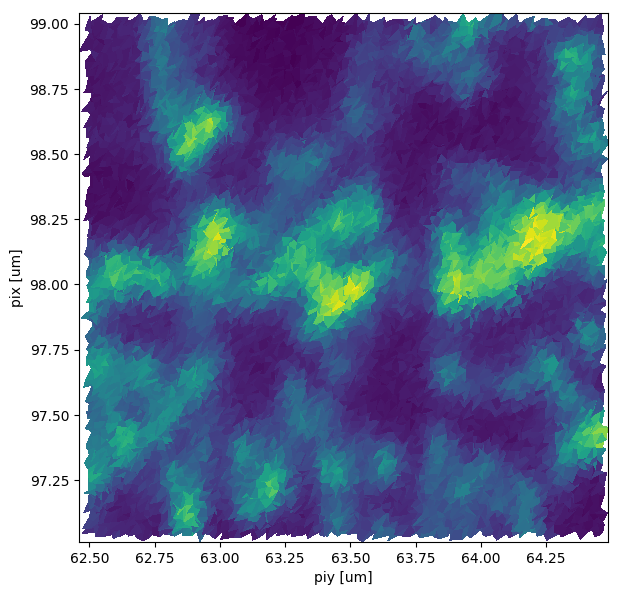

In [40]:
# to draw the smaller rois:
i = 10
piy = small_1[i]['roi1'][0]
pix = small_1[i]['roi1'][1]
roi1 = small_1[i]['roi1'][2]

fig, ax = plt.subplots(1,1,figsize=(10,7),dpi=100)

ax.pcolormesh(piy, pix, roi1)
plt.axis('image')
# plt.axis('off')
plt.ylabel('pix [um]')
plt.xlabel('piy [um]')

# ax.add_patch(patches.Rectangle((62,97),
#                     (2),
#                     (2), fill=False, edgecolor='white',linewidth=2))
# ax.add_patch(patches.Rectangle((62,92),
#                     (2),
#                     (2), fill=False, edgecolor='red',linewidth=2))
# ax.add_patch(patches.Rectangle((62,87),
#                    (2),
#                    (2), fill=False, edgecolor='red',linewidth=2))
# ax.add_patch(patches.Rectangle((66,83),
#                    (2),
#           (2), fill=False, edgecolor='red',linewidth=2))



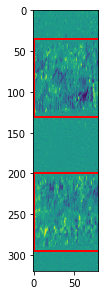

In [20]:
# display ROI being used
r1, r2 = 35, 131
r3, r4 = 200, 295

fig, ax = plt.subplots(1,1,figsize=(8*0.6,8*0.6))
ax.imshow(small_roi[15]-small_roi[16])
# ax.set_title('r1:{0}, r2:{1}'.format(r1,r2))
ax.add_patch(patches.Rectangle((0,r1),
                    (small_roi[0].shape[1]),
                    (r2-r1), fill=False, edgecolor='red',linewidth=2));
ax.add_patch(patches.Rectangle((0,r3),
                    (small_roi[0].shape[1]),
                    (r4-r3), fill=False, edgecolor='red',linewidth=2));

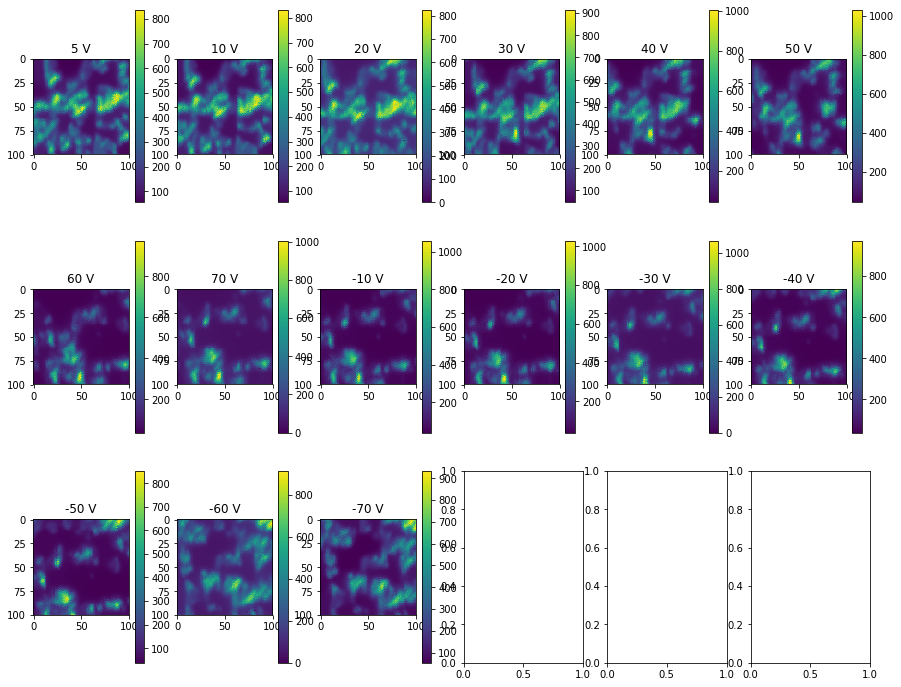

In [44]:
# denoise images (or roi)
denoised_kmaps = []
for kmap in small_roi:
    est_sigma = restoration.estimate_sigma(kmap)
    kmapd = restoration.denoise_nl_means(kmap, h=1*est_sigma, multichannel=False)
    denoised_kmaps.append(kmapd)

# plot them
plotall(denoised_kmaps)

## Shift correction

In [45]:
windows, shifts = [], []
for index in range(1, len(denoised_kmaps)):
    if index == 1:
        windows.append(denoised_kmaps[0])
        # calc shift using roi5 data - it does not change with voltage
        shift, error, diffphase = feature.register_translation(roi5[0],roi5[index])
        shifts.append(shift)
        # shift the choisen roi img with this shift
        shifted_img = nd.shift(denoised_kmaps[index],shift,order=0)
        # save the shifted img
        windows.append(shifted_img)
    else:
        shift, error, diffphase = feature.register_translation(roi5[0],roi5[index])
        shifted_img = nd.shift(denoised_kmaps[index],shift,order=0)
        windows.append(shifted_img)

In [50]:
denoised_kmaps[0].shape

(100, 100)

In [46]:
# calc largest shifts in x y - there must be a diff with the above...
shifts = []
for index in range(1,len(denoised_kmaps)):
    shift, error, diffphase = feature.register_translation(roi5[0],roi5[index])
#     print(shift)
    shifts.append(shift)

shifts = np.array(shifts)
y_max = int(abs(shifts[:,0]).max())
x_max = int(abs(shifts[:,1]).max())

print('max shift in y: {0} \nmax shift in x: {1}'.format(y_max,x_max))

# select smallest window
if shifts[:,0].max() > 0:
    winidx = np.s_[y_max:,x_max:]
elif shifts[:,0].max() <= 0:
    winidx = np.s_[:len(denoised_kmaps[0])-y_max,x_max:]
    
piy_win = small_1[scan_list[0]][roi][0][winidx]
pix_win = small_1[scan_list[0]][roi][1][winidx]

@interact(i=(0, len(windows)-1))
def plot(i=0):
    plt.imshow(windows[i][winidx], extent=(piy_win[0].min(),piy_win[0].max(),pix_win[:,0].min(),pix_win[:,0].max()))
#     plt.imshow(windows[i]) # use to see window moving
    plt.title('{0} V'.format(voltages[i]))
    plt.ylabel('pix')
    plt.xlabel('piy')
    plt.colorbar()

max shift in y: 35 
max shift in x: 19


interactive(children=(IntSlider(value=0, description='i', max=14), Output()), _dom_classes=('widget-interact',))

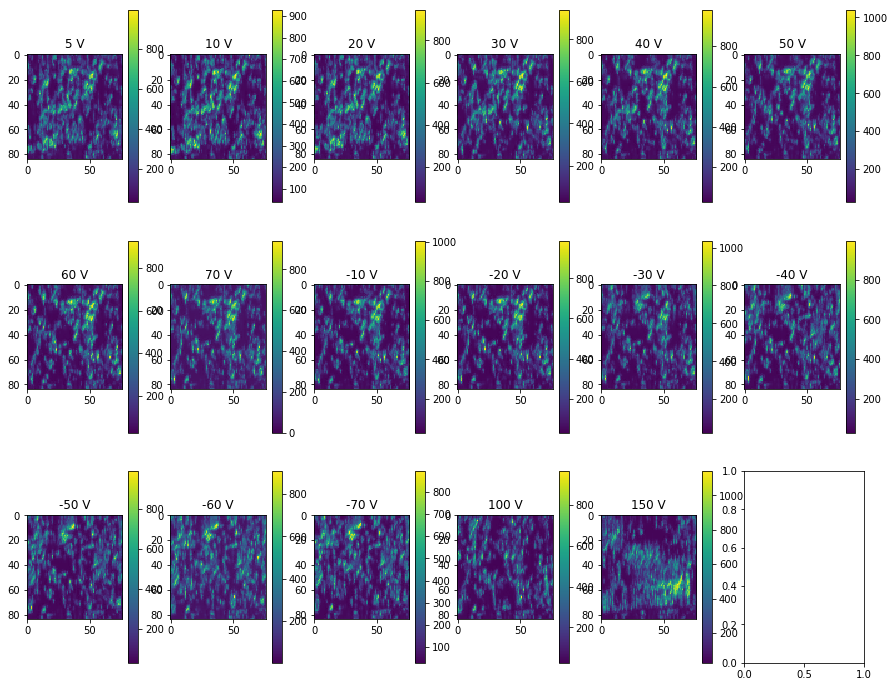

In [870]:
# replace list with only non-shifting window
for index, kmap in enumerate(windows):
    windows[index] = kmap[winidx]
    
# plot it
plotall(windows)

## Correlations

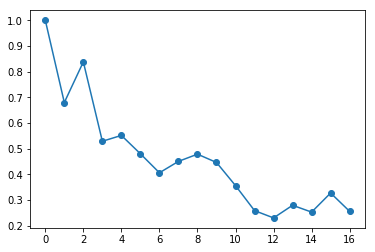

In [839]:
# structural similarity index
ssim = []

for i in range(len(windows)):
    mssim, s = measure.compare_ssim(windows[0]/windows[0].max(), windows[i]/windows[i].max(),full=True,win_size=3)
    ssim.append(mssim)

plt.plot(ssim,marker='o')

1.23099875409e+12


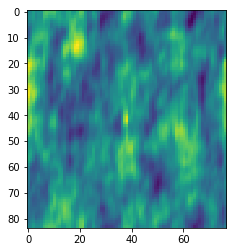

In [840]:
# cross-correlation - prob doesn't mean anything
im_prod = np.fft.fft2(windows[0 ]) * np.fft.fft2(windows[15]).conj()
cc_img = np.fft.fftshift(np.fft.ifft2(im_prod))
average_cc = cc_img.sum().sum().real
print(average_cc)
plt.imshow(cc_img.real)

In [841]:
@interact(i=(0,16,1))
def p(i=0):
    plt.imshow(windows[0]/windows[0].max()*windows[i]/windows[i].max(),vmin=0,vmax=1)
    plt.colorbar()

interactive(children=(IntSlider(value=0, description='i', max=16), Output()), _dom_classes=('widget-interact',))

/users/zatterin/Envs/py3/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


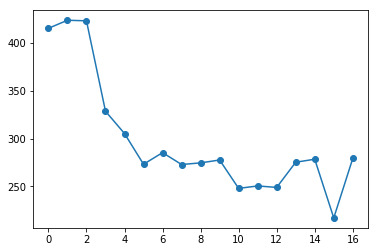

In [842]:
# cross-correlation - prob doesn't mean anything
avg_cc = []

for index in range(len(windows)):
    im_prod = np.fft.fft2(windows[0]/windows[0].max()) * np.fft.fft2(windows[index]/windows[index].max()).conj()
    cc_img = np.fft.fftshift(np.fft.ifft2(im_prod))
    average_cc = cc_img.sum().sum().real
    avg_cc.append(cc_img.max())
    
plt.plot(avg_cc, marker='o');

## Segmentation

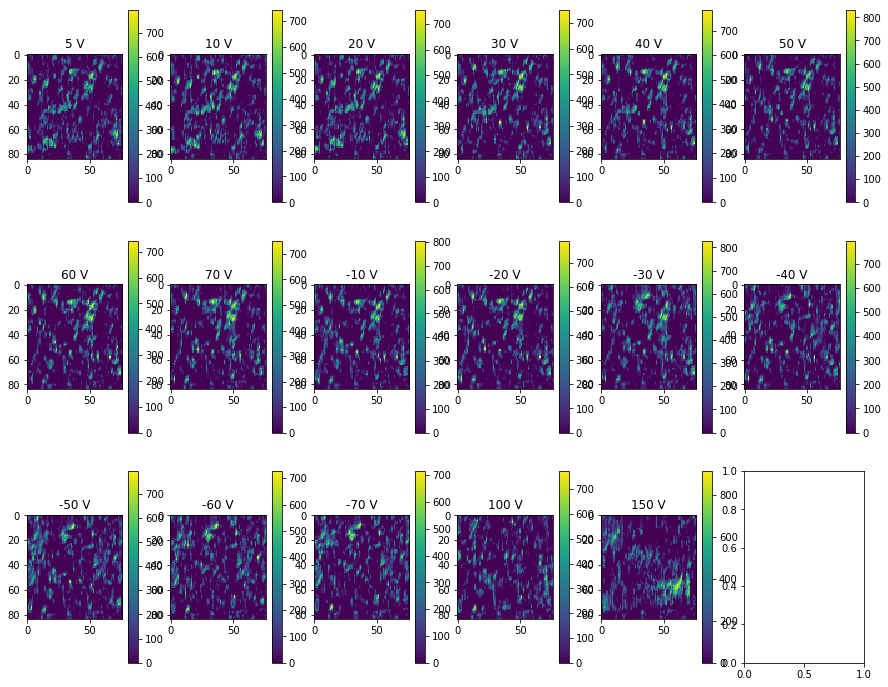

In [550]:
windows_rmax = []
# for kmap in windows:
for kmap in windows: 
    # seed and mask for rmax determination
    h = kmap.max() - kmap.max()/5# ok??
    seed = kmap - h
    mask = kmap
    se = morphology.selem.disk(1)
    
    # hmax, rmax
    hmax = morphology.reconstruction(seed, mask, method='dilation', selem=morphology.selem.disk(1))
    rmax = kmap - hmax

    # remove big low int features if any and close gaps in rmax
#     rmax_tophat = rmax - morphology.opening(rmax, selem=morphology.selem.disk(3))
    rmax_closed = morphology.closing(rmax, selem=se)
    
    # append
    windows_rmax.append(rmax_closed)

## Plot it
plotall(windows_rmax)

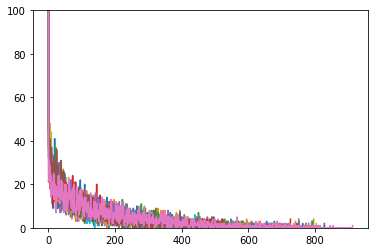

In [551]:
# inspect histograms of rmax images
for rmax in windows_rmax:
    hist, binc = exposure.histogram(rmax, nbins=int(rmax.max()))
    plt.plot(binc, hist)
    plt.ylim(0,100)

Justification for calculating threshold of image with smallest maxima in intensity: I in roi changes with voltage but we are only interested in area occupied by domains, so that should be calculated always with the same criteria. Provided of course the background is always the same, which is the case here.

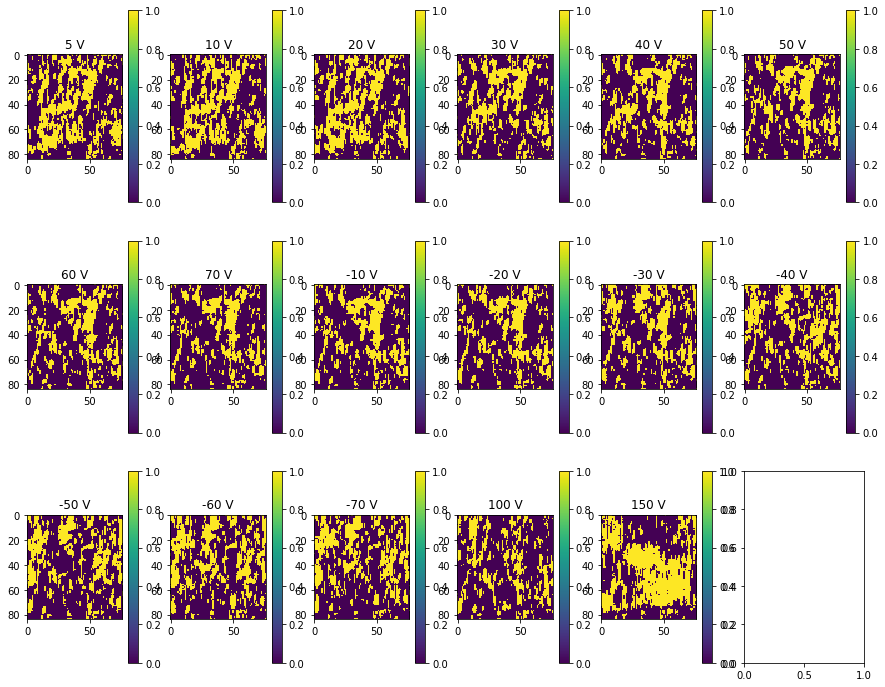

In [563]:
# maxima of all rmax
maxima = np.zeros(len(windows_rmax))
for index, rmax in enumerate(windows_rmax):
    maxima[index] = rmax.max()
    
# calc threshold of rmax image with lowest max 
ts = filters.threshold_li(windows_rmax[maxima.argmin()])

# use it to threhsold other values - should be ok since bkg==0 in rmax
windows_ts = []
for rmax in windows_rmax:
#     ts = filters.threshold_li(rmax)
    ts_rmax = rmax > ts
    windows_ts.append(ts_rmax)
    
plotall(windows_ts)

In [559]:
voltages = [5,10,20,30,40,50,60,70,-10,-20,-30,-40,-50,-60,-70,100,150] # last two only large scans

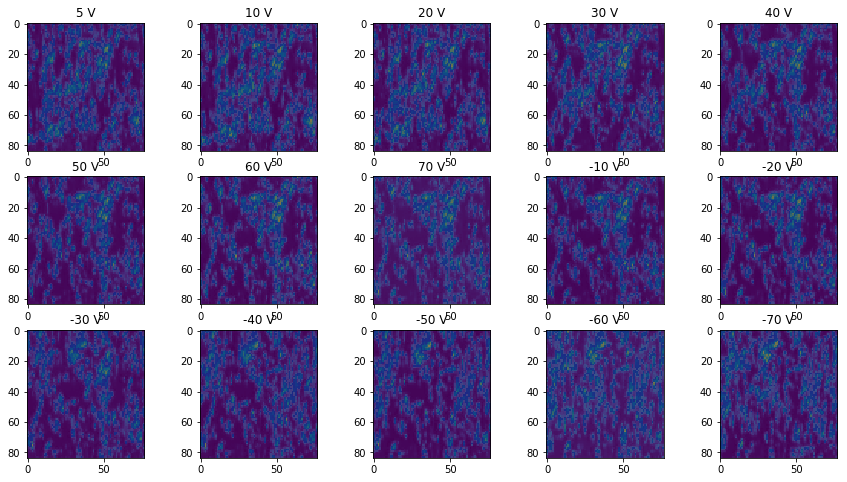

In [560]:
fig, ax = plt.subplots(3,5,figsize=(15,8))
axes = ax.ravel()

for index, ax in enumerate(axes):
    ax.imshow(windows[index],cmap='viridis')
    segmented_data = np.ma.masked_where(windows_ts[index] < 1, windows_ts[index])
    ax.imshow(segmented_data,cmap='jet',alpha=0.5)
    ax.set_title('{0} V'.format(voltages[index]))
plt.show()

## Calculations

In [561]:
domain_area = []

for index, segmented_kmap in enumerate(windows_ts):
    value, count = np.unique(segmented_kmap, return_counts=True)
    res = dict(zip(value, count))
    n = res[True]
    domain_area.append(n)

Text(0.5,0,'Voltage')

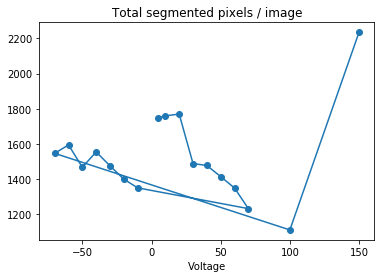

In [562]:
plt.plot(voltages,[x for x in domain_area],marker='o')
plt.title('Total segmented pixels / image')
plt.xlabel('Voltage')

## Save data
And look at it

In [753]:
tot_domain_a1 = np.load('a1_area.npy').item()

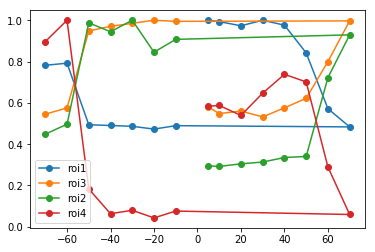

In [757]:
voltages = [5,10,20,30,40,50,60,70,-10,-20,-30,-40,-50,-60,-70]
plt.plot(voltages, tot_domain_a1['roi1'] / max(tot_domain_a1['roi1']) ,marker='o', label='roi1')
plt.plot(voltages, tot_domain_a1['roi3'] / max(tot_domain_a1['roi3']),marker='o', label='roi3')
plt.plot(voltages, [abs(-x) for x in tot_domain_a1['roi2']] / max(tot_domain_a1['roi2']),marker='o', label='roi2')
plt.plot(voltages, [abs(-x) for x in tot_domain_a1['roi4']] / max(tot_domain_a1['roi4']),marker='o', label='roi4')
plt.legend();

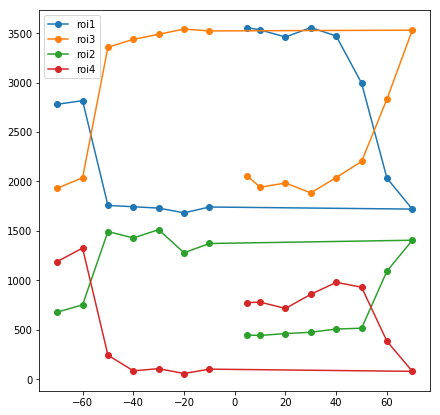

In [758]:
fig = plt.figure(figsize=(7,7))

plt.plot(voltages, tot_domain_a1['roi1'] ,marker='o', label='roi1')
plt.plot(voltages, tot_domain_a1['roi3'],marker='o', label='roi3')
plt.plot(voltages, tot_domain_a1['roi2'],marker='o', label='roi2')
plt.plot(voltages, tot_domain_a1['roi4'],marker='o', label='roi4')
plt.legend();

## Watershed

990.0


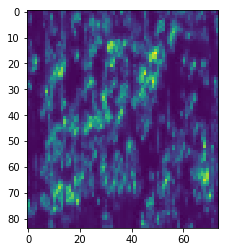

In [660]:
kmap = windows[0]
print(kmap.max())
plt.imshow(kmap);

Text(0.5,1,'Watershed')

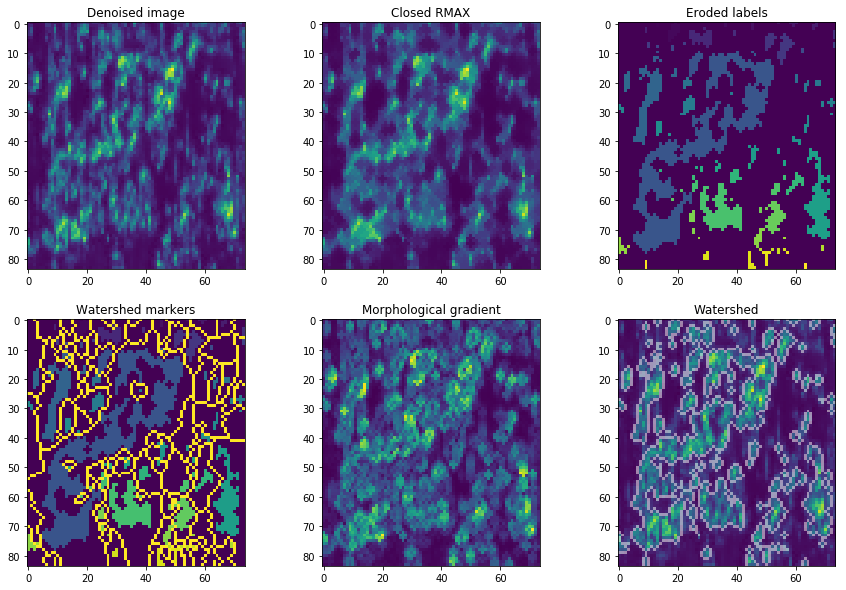

In [777]:
## Determine Regional maxima
# denoise the image
# sigma_est = restoration.estimate_sigma(kmap)
# kmapd = restoration.denoise_nl_means(kmap, h=0.8*sigma_est)
kmapd = kmap
# make seed and mask for regional max determination
h = 980
seed_rmax = kmapd - h
mask_rmax = kmapd
# HMAX: reconstruction by dilation
hmax = morphology.reconstruction(seed_rmax, mask_rmax, method='dilation', selem=morphology.selem.disk(1))
# RMAX
rmax = kmapd - hmax
# close gaps in rmax
rmax = morphology.closing(rmax, selem=morphology.selem.disk(1)) 
# treshold closed rmax
ots = filters.threshold_otsu(rmax, nbins=int(rmax.max())) 
ts_rmax = rmax > ots # binary rmax
# erode: sure fg pixels
# ts_rmax = morphology.binary_erosion(ts_rmax, selem=morphology.selem.disk(1))
# label thresholded rmax
inner_markers, nlabels = morphology.label(ts_rmax, neighbors=4, return_num=True) 

## Watershed
# use labeled rmax markers are basin markers in negated kmap
wshed_bkg = morphology.watershed(-kmapd, inner_markers, watershed_line=True)
# watershed bkg lines are given max integer label
lines = (wshed_bkg==0).astype('int8')
lines[wshed_bkg==0] = nlabels + 1
# total markers for watershed
markers = inner_markers + lines
# morpho gradient
mgrad = morphology.dilation(kmap,selem=morphology.selem.disk(1)) - morphology.erosion(kmap,selem=morphology.selem.disk(1))
# watershed
wshed = morphology.watershed(mgrad, markers, watershed_line=True)
wshed_line = np.ma.masked_where(wshed!=0,wshed)

## Plot
fig, axes = plt.subplots(2,3, figsize=(15,10))
ax = axes.ravel()

ax[0].imshow(kmapd) # denoised image
ax[0].set_title('Denoised image')
ax[1].imshow(rmax) # closed regional max
ax[1].set_title('Closed RMAX')
ax[2].imshow(inner_markers) # eroded labels
ax[2].set_title('Eroded labels')
ax[3].imshow(markers) # inner and outer watershed markers
ax[3].set_title('Watershed markers')
ax[4].imshow(mgrad) # morpho gradient of original image
ax[4].set_title('Morphological gradient')
ax[5].imshow(kmap)
# ax[5].imshow(wshed==0,cmap='Reds',alpha=0.3) # final watershed
ax[5].imshow(wshed_line,cmap='Reds',alpha=0.5)
ax[5].set_title('Watershed')

## Single thresholding

In [873]:
def thresholdit(kmap, se=morphology.selem.disk(1)):
    # rmax
    h = kmap.max() - kmap.max()/20
    seed_rmax = kmap - h
    mask_rmax = kmap
    hmax = morphology.reconstruction(seed_rmax, mask_rmax, method='dilation', selem=se)
    rmax = kmap - hmax

    # close gaps in rmax / open small areas
    rmax = morphology.closing(rmax, selem=se) 
    rmax = morphology.opening(rmax, selem=se) 

    # threshold
    ts = filters.threshold_li(rmax)
    ts_rmax = rmax > ts
    
    return ts_rmax

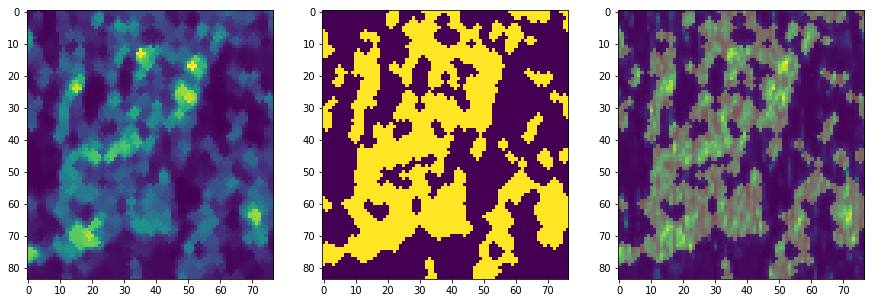

In [875]:
# load 
kmap = windows[0]

# threshold
ts_rmax = thresholdit(kmap)

# plot
fig, ax = plt.subplots(1,3,figsize=(15,6))

ax[0].imshow(rmax)
ax[1].imshow(ts_rmax)
ax[2].imshow(kmap)
ax[2].imshow(ts_rmax,alpha=0.3);

In [872]:
# mask the image
mask = np.ma.masked_where(ts_rmax > 0, ts_rmax)
mask_i = np.ma.masked_where(ts_rmax == 0, ts_rmax)

# visualise how stuff below mask changes with V
@interact(i=(0,16,1))
def p(i=0):
    fig, ax = plt.subplots(1,3,figsize=(12,5))
    fig.suptitle(str(voltages[i])+' V')
    ax[0].imshow(windows[i]/windows[i].max(), vmin=0,vmax=1)
    ax[0].imshow(mask)
    ax[1].imshow(windows[i]/windows[i].max(), vmin=0,vmax=1)
    ax[1].imshow(mask_i)
    ax[2].imshow(windows[i]/windows[i].max(), vmin=0,vmax=1)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='i', max=16), Output()), _dom_classes=('widget-interact',))

In [876]:
thresholds = []

for kmap in windows:
    thresholds.append(thresholdit(kmap))

In [882]:
# mask the image
mask = np.ma.masked_where(ts_rmax > 0, ts_rmax)
mask_i = np.ma.masked_where(ts_rmax == 0, ts_rmax)

# visualise how stuff below mask changes with V
@interact(i=(0,16,1))
def p(i=0):
    fig, ax = plt.subplots(1,3,figsize=(12,5))
    fig.suptitle(str(voltages[i])+' V')
    ax[0].imshow(thresholds[i])
    ax[0].imshow(mask)
    ax[1].imshow(thresholds[i])
    ax[1].imshow(mask_i)
    ax[2].imshow(thresholds[i])
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='i', max=16), Output()), _dom_classes=('widget-interact',))

In [897]:
aa1, aa2 = [], []

for i in range(len(windows)-1):
    aa1.append(np.count_nonzero(thresholds[i][ts_rmax > 0]))
    aa2.append(np.count_nonzero(thresholds[i][ts_rmax == 0]))

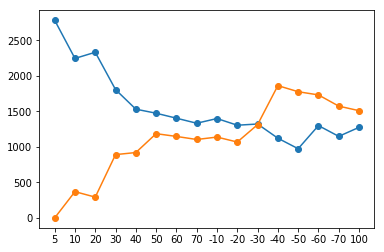

In [898]:
plt.plot(aa1,marker='o')
plt.plot(aa2,marker='o')
plt.xticks(range(16),voltages);

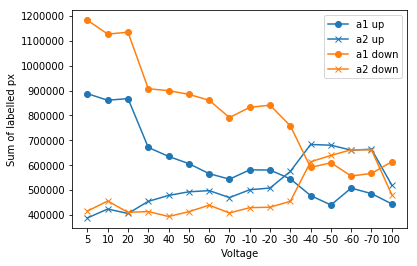

In [856]:
a1o, a2o = [], []
for i in range(len(windows)-1):
    a1d = windows[i][mask].sum() # not quite correct... think about it
    a2d = windows[i][np.logical_not(mask)].sum()
    a1o.append(a1d)
    a2o.append(a2d)
    
plt.plot(a1, c='C0', marker='o', label='a1 up')
plt.plot(a2, c='C0', marker='x', label='a2 up')
plt.plot(a1o, c='C1', marker='o', label='a1 down')
plt.plot(a2o, c='C1', marker='x', label='a2 down')

plt.xticks(range(16),voltages)
plt.legend()
plt.xlabel('Voltage')
plt.ylabel('Sum of labelled px')
plt.show()